## Step 1. Data Processing

### 1.1 Get Dataset
1. Follow the instruction from [IMGUR5K Handwriting Dataset Repository](https://github.com/facebookresearch/IMGUR5K-Handwriting-Dataset) to collect the dataset.

2. Uploaded the dataset to your Google Drive

### 1.2 Import Dataset

In [ ]:
# Connect your Google Drive with Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !mkdir /content/drive

In [3]:
# your path to image dataset in Google Drive
# image_dataset_path = '/content/drive/MyDrive/Academic/Spring 2025/CS439/project/dataset'
image_dataset_path = "./dataset"
# input your path:
# image_dataset_path = input("Path to image dataset in Google Drive: ")

In [4]:
'''
return a DataFrame of image Dataset
with two column:
id (as labeled in the dataset): each image has a unique id
url: url of the source of the image
'''
import os
import pandas as pd

def create_image_df():
    assert image_dataset_path is not None, "Set image dataset to the folder that include IMGUR5K Handwriting Dataset "
    # List to hold file names (without extensions)
    ids = []

    # Iterate over all files in the directory
    for filename in os.listdir(image_dataset_path):
        # Get the full path of the file
        full_path = os.path.join(image_dataset_path, filename)

        # Skip directories, only process files
        if os.path.isfile(full_path):
            # Split the filename into name and extension
            name, _ = os.path.splitext(filename)

            # Add the file name (without extension) to the list
            ids.append(name)

    # Create a DataFrame with two columns: ids and url
    df = pd.DataFrame({
        "id": ids
    })

    return df


# call function
df = create_image_df()

In [5]:
# overview of df
df.head()

,id
0,7u2pNft
1,EHXbhtL
2,O91MhJ1
3,eLbkWRb
4,bu3PxuZ


In [6]:
from PIL import Image

def read_image(path):
  image = Image.open(path).convert("RGB")
  return image

In [7]:
# quick access to image in the dataset
def read_my_image(index):
  assert image_dataset_path is not None, "Set image dataset to the folder that include IMGUR5K Handwriting Dataset "
  path = image_dataset_path+"/"+ str(index) + '.jpg'
  return read_image(path)

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def print_image(index):
  # Read the image
  img = read_my_image(index)  # Replace 'index' with your actual index

  # Display the image in a smaller size
  plt.figure(figsize=(10, 6))  # Adjust width and height in inches
  plt.imshow(img)
  plt.axis('off')  # Turn off axis numbers and ticks
  plt.show()

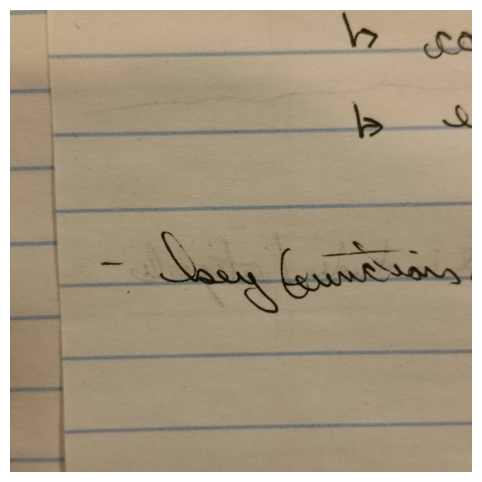

In [9]:
# check image in df
print_image("EHXbhtL")

### 1.3 Label Ground Truth Text

In [10]:
import csv
# Get data infomation from the lst
data_info = './dataset_info/imgur5k_data.lst'

# Read url: actual url of the image
# Location: the location of the text based on the image
# text: Ground Truth Text
df_info = pd.read_csv(data_info, sep='\t', header=None, names=['url', 'location', 'text'], quoting=csv.QUOTE_NONE, )

# Extract the 'id' from the URL
df_info['id'] = df_info['url'].apply(lambda x: x.split('/')[-1].split('.')[0])

# Reorder columns to match the desired output
df_info = df_info[['id', 'url', 'location', 'text']]

In [11]:
df = pd.merge(df, df_info, on='id', how='left')

In [12]:
df.head()

,id,url,location,text
0,7u2pNft,https://i.imgur.com/7u2pNft.jpg,"[1442.0, 2979.5, 900.5, 1393.0, -0.5]",4
1,EHXbhtL,https://i.imgur.com/EHXbhtL.jpg,"[1695.5, 103.5, 232.0, 196.5, 1.5]",↳
2,EHXbhtL,https://i.imgur.com/EHXbhtL.jpg,"[2090.5, 178.5, 286.0, 199.5, 0.5]",co
3,EHXbhtL,https://i.imgur.com/EHXbhtL.jpg,"[1735.0, 521.0, 176.5, 238.0, 8.5]",↳
4,EHXbhtL,https://i.imgur.com/EHXbhtL.jpg,"[2158.0, 525.0, 174.0, 179.5, 9.0]",.


In [13]:
df = df.dropna()

In [14]:
len(df)

227055

## Step 2. Base Model Evaluation

### 2.1 Import Base Model
The base model is from [TrOCR](https://huggingface.co/microsoft/trocr-base-handwritten) (base-sized model, fine-tuned on IAM) model fine-tuned on the IAM dataset. We accessed it with Hugging Face

In [15]:
# import base model
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transfor

In [16]:
# input: image as RGB and model to process
# output: text
def image_to_text(model, image):
  pixel_values = processor(images=image, return_tensors="pt").pixel_values
  generated_ids = model.generate(pixel_values)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  return generated_text

### 2.2 Test Pre-trained Model

We select several different complexity and format of images in our dataset to test the capacity of the pre-trained model

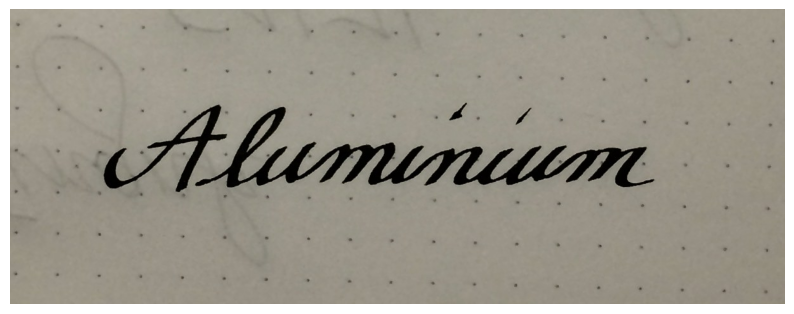

In [17]:
#  single word, no angle
print_image("a0zqSCF")

In [18]:
# test base model on single word image
image = read_my_image("a0zqSCF")
text = image_to_text(model, image)
print(text)

Aluminium


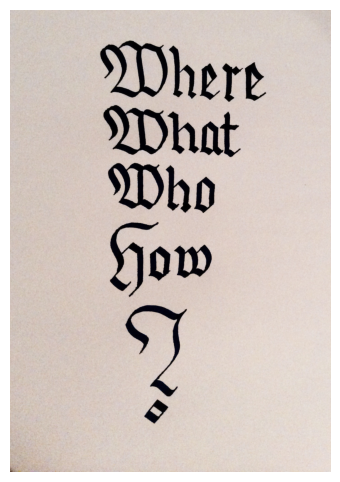

In [19]:
# multi-line, single word no angle
print_image("ZIsH9sg")

In [ ]:
image = read_my_image("ZIsH9sg")
text = image_to_text(model, image)
print(text)

In [ ]:
# single line, multi-word, slightly angled
print_image("9W9vgCw")

In [ ]:
image = read_my_image("9W9vgCw")
text = image_to_text(model, image)
print(text)

In [ ]:
df[df['id']=='9W9vgCw']

In [ ]:
# single line, multi word, no angle
print_image("7buo10E")

In [ ]:
image = read_my_image("7buo10E")
text = image_to_text(model, image)
print(text)

In [ ]:
print_image("y7YkG7L")

In [ ]:
image = read_my_image("y7YkG7L")
text = image_to_text(model, image)
print(text)

In [ ]:
print_image("d3JaHtH")

In [ ]:
image = read_my_image("d3JaHtH")
text = image_to_text(model, image)
print(text)

#### Conlusion
1. *Single-word, single-line, no angle*: Highest successes, depedning on the complexity of each style, but the model is able to process the characters and read the basics
2. *Multi-word, single-line, no angle*: The model has some more difficulties, a little less acurate than single word
3. *Single-word, single-line, no angle*:
4. *Single-word, single-line, no angle*:

## Step 3. Fine-tune On Whole-page Images
We would first fine-tune the model on original dataset, which are full-page images.  

### 3.1 Get Dataset based on full image

In [20]:
# remove unrelated columns for full images
df_full_images = df.drop(['url','location'], axis=1)

In [21]:
df_full_images= df.groupby('id')['text'].agg(lambda x: ' '.join(map(str, x))).reset_index()

In [22]:
df_full_images['text']=df_full_images['text'].astype(str)

In [23]:
df_full_images.head()

,id,text
0,00J8wDc,.
1,00fKvsn,S A S A SA SA S A SAB > < ﹀ S A SAB SAB S S A ...
2,01E8WIc,nàgot
3,01dWS6L,/buns spritE Tomato vanilla cakE 1:45 pm Gift:...
4,01xGl1w,never give up on something you can't go a day ...


### 3.2 Format Dataset for training

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class StyleDataset(Dataset):
    def __init__(self, df, processor, max_target_length=256):
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      try:
          text = self.df['text'][idx]
          if not isinstance(text, str) or not text.strip():
              raise ValueError(f"Invalid text at index {idx}: {repr(text)}")
          image_id = self.df['id'][idx]
          try:
              image = read_my_image(image_id)
          except Exception as e:
              raise ValueError(f"Failed to load image for ID {image_id} at index {idx}") from e
          try:
              pixel_values = self.processor(image, return_tensors="pt").pixel_values
          except Exception as e:
              raise ValueError(f"Image processing failed at index {idx}") from e

          if torch.isnan(pixel_values).any() or torch.isinf(pixel_values).any():
              raise ValueError(f"Invalid pixel values (NaN/inf) at index {idx}")
          try:
              labels = self.processor.tokenizer(
                  text,
                  padding="max_length",
                  max_length=self.max_target_length
              ).input_ids
          except Exception as e:
              raise ValueError(f"Tokenization failed for text at index {idx}") from e

          # Replace pad_token_id with -100 for loss masking
          labels = [
              label if label != self.processor.tokenizer.pad_token_id else -100
              for label in labels
          ]
          encoding = {
              "pixel_values": pixel_values.squeeze(),
              "labels": torch.tensor(labels)
          }

          if encoding["pixel_values"].dim() != 3:
              raise ValueError(f"Invalid pixel_values shape at index {idx}")

          if encoding["labels"].numel() != self.max_target_length:
              raise ValueError(f"Labels length mismatch at index {idx}")

          return encoding

      except Exception as e:
          print(f"\nError in sample {idx}:")
          print(f"   Error type: {type(e).__name__}")
          print(f"   Details: {str(e)}")
          if hasattr(e, '__cause__') and e.__cause__:
              print(f"   Underlying error: {type(e.__cause__).__name__}: {str(e.__cause__)}")
          print(f"   DataFrame row:\n{self.df.iloc[idx]}")
          return None

### 3.2 Divide Into Validation and Training sets

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

train_df, eval_df = train_test_split(df_full_images, test_size=0.2, random_state=42)

# train_df = train_df.reset_index(drop=True)
# eval_df = eval_df.reset_index(drop=True)

# Split into validation and training sets
train_dataset = StyleDataset(df=train_df,processor=processor)
eval_dataset= StyleDataset(df=eval_df,processor=processor)

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

### 3.3 Full-page Image


In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    output_dir="./output/",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

In [ ]:
!pip install evaluate jiwer

In [ ]:
from evaluate import load

cer_metric = load("cer")

In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
print_image("GI4v6rg")

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

In [25]:
df.dropna()

,id,url,location,text
0,7u2pNft,https://i.imgur.com/7u2pNft.jpg,"[1442.0, 2979.5, 900.5, 1393.0, -0.5]",4
1,EHXbhtL,https://i.imgur.com/EHXbhtL.jpg,"[1695.5, 103.5, 232.0, 196.5, 1.5]",↳
2,EHXbhtL,https://i.imgur.com/EHXbhtL.jpg,"[2090.5, 178.5, 286.0, 199.5, 0.5]",co
3,EHXbhtL,https://i.imgur.com/EHXbhtL.jpg,"[1735.0, 521.0, 176.5, 238.0, 8.5]",↳
4,EHXbhtL,https://i.imgur.com/EHXbhtL.jpg,"[2158.0, 525.0, 174.0, 179.5, 9.0]",.
...,...,...,...,...
227078,SPQk0RG,https://i.imgur.com/SPQk0RG.jpg,"[1849.0, 1950.0, 342.0, 83.0, 2.0]","Rather,"
227079,SPQk0RG,https://i.imgur.com/SPQk0RG.jpg,"[2122.0, 1943.0, 93.0, 78.0, 1.0]",in
227080,SPQk0RG,https://i.imgur.com/SPQk0RG.jpg,"[2292.0, 1924.0, 128.0, 77.0, 1.0]",his
227081,SPQk0RG,https://i.imgur.com/SPQk0RG.jpg,"[2666.0, 1938.0, 516.0, 114.0, 0.0]",questoning


## Step 4. Fine-Tuning on Words
Fine-tuning the model based on single words from each image.

### 4.1 Cropping Each Word from the Training Images

In [26]:
# remove unrelated columns
df_words = df.drop(['url'], axis=1)

In [27]:
df_words.head()

,id,location,text
0,7u2pNft,"[1442.0, 2979.5, 900.5, 1393.0, -0.5]",4
1,EHXbhtL,"[1695.5, 103.5, 232.0, 196.5, 1.5]",↳
2,EHXbhtL,"[2090.5, 178.5, 286.0, 199.5, 0.5]",co
3,EHXbhtL,"[1735.0, 521.0, 176.5, 238.0, 8.5]",↳
4,EHXbhtL,"[2158.0, 525.0, 174.0, 179.5, 9.0]",.


In [72]:
import math
import numpy as np

# gets the corner points of the rectangle
def get_rotated_rectangle_corners(xc, yc, w, h, a):
    # Convert angle to radians
    angle_rad = math.radians(a)
    cos_a = math.cos(angle_rad)
    sin_a = math.sin(angle_rad)

    # Unrotated corners relative to the center
    corners_relative = [
        (-w / 2, -h / 2),  # Top-left
        (w / 2, -h / 2),    # Top-right
        (w / 2, h / 2),     # Bottom-right
        (-w / 2, h / 2)      # Bottom-left
    ]

    # Rotate and translate corners
    corners = []
    for x, y in corners_relative:
        x_rot = x * cos_a - y * sin_a + xc
        y_rot = x * sin_a + y * cos_a + yc
        corners.append((x_rot, y_rot))

    # Reorder to left-top, right-top, right-bottom, left-bottom
    # The order is already correct as per the relative corners definition
    return np.array(corners)

In [73]:
import cv2
import numpy as np
import random


# gets the cropped, straightened image of the word at the specified location on the specified image
def normalized_words(image_path, xc, yc, w, h, angle) :
    # Open image with PIL first (as before)
    pil_image = Image.open(image_path)
    pil_image = pil_image.convert('RGB')
    pil_image_array = np.array(pil_image)
    
    # Convert PIL image to raw bytes
    _, img_bytes = cv2.imencode('.jpg', pil_image_array)  # Encode to raw byte array
    
    # Decode using OpenCV
    image = cv2.imdecode(img_bytes, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"[ERROR] OpenCV imdecode() failed to decode image: {image_path}")
    

    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    

    corners = get_rotated_rectangle_corners(xc, yc, w, h, -angle) # angle is negated to rotate according to this function
    corners = corners.astype(np.float32) # This line ensures corners are the correct data type
    
    # Define the width and height for the output image (you could compute this based on the rectangle size)
    width = int(np.linalg.norm(corners[0] - corners[1]))
    height = int(np.linalg.norm(corners[0] - corners[3]))
    
    # Define the destination points (the rectangle we want to map the original slanted rectangle to)
    dst_points = np.array([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]], dtype="float32")
    
    # Get the perspective transform matrix (tells how much to rotate the image)
    matrix = cv2.getPerspectiveTransform(corners, dst_points)
    
    # Apply the perspective transformation to get the cropped image
    cropped_image = cv2.warpPerspective(image, matrix, (width, height))
    
    return cropped_image # numpy array (width, height, rgb_channels)

In [74]:
df_words.info()
len(df_words)

<class 'pandas.core.frame.DataFrame'>
Index: 227055 entries, 0 to 227082
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        227055 non-null  object
 1   location  227055 non-null  object
 2   text      227055 non-null  object
dtypes: object(3)
memory usage: 6.9+ MB


227055

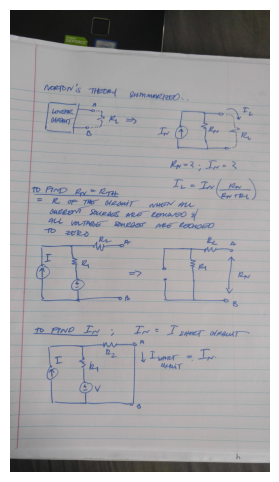

In [75]:
df_words.head(227055)
df_words.head(10)
print_image("O91MhJ1")

In [78]:
images = []

In [ ]:
import re

images = []  # reset just to be sure

for i, row in df.iterrows():
    image_path = image_dataset_path + '/' + row['id'] + '.jpg'
    word_location = row['location']
    matches = re.findall(r'\d+\.\d+', word_location)
    xc, yc, w, h, a = map(float, matches)

    # print(f"[{i}] ID: {row['id']}  |  Image path: {image_path}")

    cropped_image = normalized_words(image_path, xc, yc, w, h, a)
    images.append(cropped_image)
    if (i % 100) == 0:
        print(i)
    
    # print(i)

0
100
200
300
400
500
600
700
800
900


In [ ]:
for img in images:
    plt.imshow(img)
    plt.show()

In [ ]:
df_words.info()

In [ ]:
df_words['image'] = images

In [37]:
len(images)
# images

1002

In [ ]:
df_words_csv = pd.DataFrame(df_words)
df_words_csv.info()

In [ ]:
df_words_csv.to_csv('df_words.csv', index=False)

In [ ]:
for img in df_words_csv.iloc[:,3]:
    plt.imshow(img)
    plt.show()

In [38]:
# save list

import pickle
file_path = './imglist_0_1002.pkl'
with open('./imglist_0_1002.pkl', 'wb') as file:
    pickle.dump(images, file)

In [ ]:
# move list to drive (if saved in local accidentally)
# !cp imglist_0_20000.pkl /content/drive/MyDrive/

In [41]:
# load list (if needed)

with open('./imglist_0_1002.pkl', 'rb') as file:
    loaded_list = pickle.load(file)

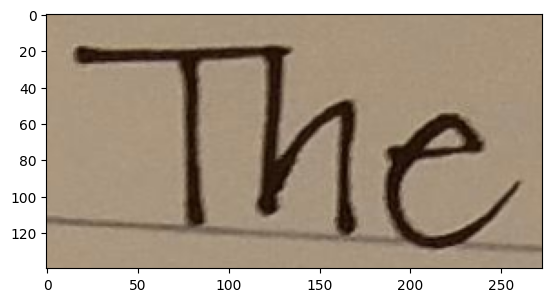

In [49]:
len(loaded_list)
plt.imshow(loaded_list[1001])
plt.show()

In [54]:
# Slice the first 1002 rows
df_subset = df.iloc[:1002]

# Convert each column to its own list
id_list = df_subset['id'].tolist()
text_list = df_subset['text'].tolist()

In [55]:
# Create the DataFrame
df_1002 = pd.DataFrame({
    'id': id_list,
    'text': text_list,
    'image': images  # Each row will hold a NumPy array
})

In [60]:
# save dataframe

import pickle
file_path = './dfwords_0_1002.pkl'
with open('./dfwords_0_1002.pkl', 'wb') as file:
    pickle.dump(df_1002, file)

In [61]:
with open('./dfwords_0_1002.pkl', 'rb') as file:
    loaded_dfwords = pickle.load(file)

In [71]:
loaded_dfwords.iloc[1001]

id                                                 8jGV1JA
text                                                   The
image    [[[172, 152, 127], [169, 149, 124], [167, 147,...
Name: 1001, dtype: object

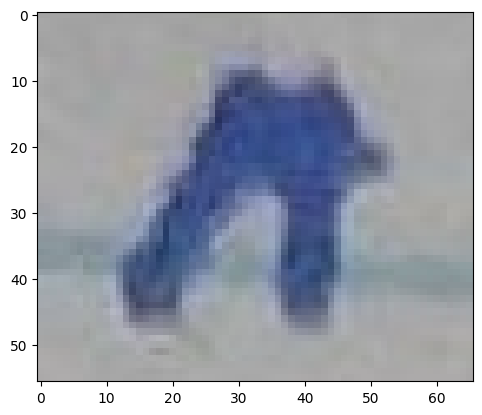

In [68]:
plt.imshow(loaded_dfwords.iloc[10,2])
plt.show()

In [ ]:
!nvidia-smi


In [ ]:
# from PIL import Image

# def check_image(image_path):
#     try:
#         img = Image.open(image_path)
#         img.verify()  # This checks the file for integrity, doesn't decode it fully
#         print(f"[INFO] Image {image_path} is valid.")
#     except Exception as e:
#         print(f"[ERROR] Image {image_path} is corrupted: {e}")

# check_image("./dataset/ubywyB9.jpg")

In [ ]:
import pandas as pd
df_words_readin = pd.read_csv('df_words.csv')
df_words_readin.info()

In [ ]:
import pandas as pd
import numpy as np
import re

def clean_image_string_to_array(image_str):
    try:
        if not isinstance(image_str, str):
            print("Skipping non-string entry.")
            return None

        # Extract pixel values from the string
        numbers = list(map(int, re.findall(r'\d+', image_str)))

        # Debug: Print length of numbers
        print(f"Extracted {len(numbers)} pixels.")
        
        if len(numbers) < 3:
            print(f"Skipping image with less than 3 pixels.")
            return None

        # Calculate total pixels (width * height)
        num_pixels = len(numbers)
        
        # Each pixel is represented by 3 values (RGB), so we need the number of pixels divisible by 3
        if num_pixels % 3 != 0:
            print(f"Skipping image, the number of pixels is not divisible by 3")
            return None

        # Now, we need to infer the width and height for each image. This is a flexible approach:
        # Let's try and figure out a possible height/width combination for the image.
        # We'll try finding height and width that match the pixel count
        num_pixels_per_channel = num_pixels // 3  # RGB image (3 values per pixel)

        height, width = None, None
        # Try different height/width combinations
        for possible_height in range(1, int(np.sqrt(num_pixels_per_channel)) + 1):
            if num_pixels_per_channel % possible_height == 0:
                possible_width = num_pixels_per_channel // possible_height
                # If we find a valid height and width, we reshape the image
                print(f"Reshaping image to ({possible_height}, {possible_width}, 3)")
                height, width = possible_height, possible_width
                break

        # If we found a valid height and width, reshape the image
        if height and width:
            array = np.array(numbers, dtype=np.uint8).reshape((height, width, 3))
            return array
        else:
            print(f"Unable to find valid dimensions for image. Skipping...")
            return None

    except Exception as e:
        print(f"Error rebuilding image array: {e}")
        return None

In [ ]:
df_words_readin['image'] = df_words_readin['image'].astype(str)
# df_words_readin = df_words_readin[df_words_readin['image'].notnull()]
# df_words_readin = df_words_readin[~df_words_readin['image'].str.lower().isin(['nan', ''])]
df_words_readin['image'] = df_words_readin['image'].apply(lambda x: clean_image_string_to_array(x))

# df_words_readin['image'] = df_words_readin['image'].apply(lambda x: clean_image_string_to_array(x, shape_guess=(224, 224, 3)))


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(df_words_readin['image'][0])
plt.show()

In [ ]:
import ast

import matplotlib.pyplot as plt
for i, row in df_words_readin.iterrows():
    print(row['id'], row['text'])
    image_list = ast.literal_eval(row['image'])  # Safer than eval
    image_array = np.array(image_list, dtype=np.uint8)
    plt.imshow(image_array)
    plt.show()

In [ ]:
print(type(df_words_readin.loc[0, 'image']))
print(df_words_readin.loc[0, 'image'][:100])  # First 100 chars if it's a string